# Basic UD Part-of-speech Analysis

Fairly basic analysis involving POS tags on some Universal Dependencies corpora

In [1]:
import sys
sys.path.append('../')

from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

import src.corpus

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Parse the corpus

In [2]:
#UD_FILE = "../data/zh_gsd-ud-train.conllu"
#UD_FILE = "../data/en_ewt-ud-train.conllu"
#UD_FILE = "../data/ja_gsd-ud-train.conllu"

BNC_FILE = "../data/bnc/bnc.pkl"

corpus = src.corpus.POSCorpus.create_from_bnc_pickled(data_file_path=BNC_FILE)

In [3]:
# Define the two POS (NOUN, VERB, ADJ) to compare for the rest of the analysis
POS1 = 'NOUN'
POS2 = 'VERB'

## POS counts

In [4]:
pos_counts = defaultdict(int)

for sentence in corpus.sentences:
  for token in sentence:
    pos_tag = token['pos']
    if pos_tag:
      pos_counts[pos_tag] += 1

<BarContainer object of 21 artists>

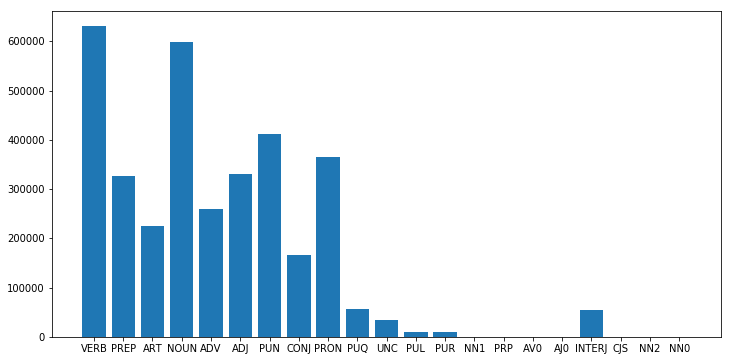

In [5]:
plt.figure(figsize=(12, 6))
plt.bar(pos_counts.keys(), pos_counts.values())

In [6]:
lemma_count_df = corpus.get_per_lemma_stats(POS1=POS1, POS2=POS2)
lemma_count_df.sort_values('total_count', ascending=False).head(20)

,lemma,pos1_count,pos2_count,majority_tag,total_count,minority_count,minority_ratio,is_flexible
0,be,0,147915,VERB,147915,0,0.000000,False
29,have,3,51743,VERB,51746,3,0.000058,False
8,do,6,34673,VERB,34679,6,0.000173,False
2166,get,0,16679,VERB,16679,0,0.000000,False
52,say,10,14151,VERB,14161,10,0.000706,False
149,go,293,13786,VERB,14079,293,0.020811,False
118,know,0,12551,VERB,12551,0,0.000000,False
227,will,147,12273,VERB,12420,147,0.011836,False
642,can,35,11480,VERB,11515,35,0.003040,False
521,would,0,9894,VERB,9894,0,0.000000,False


## Distribution of lemmas

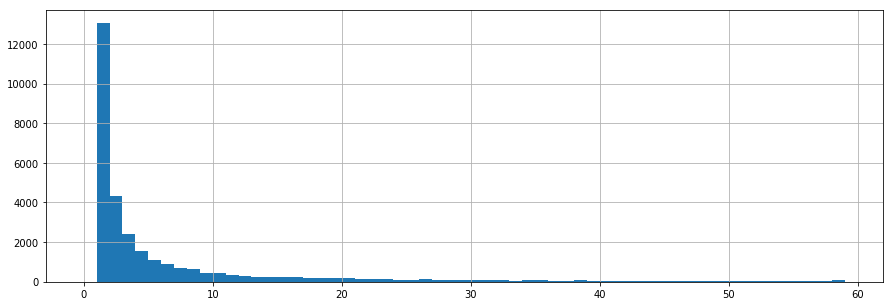

In [7]:
plt.figure(figsize=(15, 5))
lemma_count_df['total_count'].hist(bins=range(0, 60))

## Syntax flexibility metrics

In [8]:
# Only consider lemmas with at least 5 usages
lemma_count_df = lemma_count_df[lemma_count_df['total_count'] >= 5].sort_values('total_count', ascending=False)
pos1_lemmas = len(lemma_count_df[lemma_count_df['majority_tag'] == POS1])
pos2_lemmas = len(lemma_count_df[lemma_count_df['majority_tag'] == POS2])
pos1_flexibility = len(lemma_count_df[(lemma_count_df['majority_tag'] == POS1) & (lemma_count_df['is_flexible'])]) / pos1_lemmas
pos2_flexibility = len(lemma_count_df[(lemma_count_df['majority_tag'] == POS2) & (lemma_count_df['is_flexible'])]) / pos2_lemmas

In [9]:
print('%s Flexibility = P(flexible | %s): %0.9f' % (POS1, POS1, pos1_flexibility))

NOUN Flexibility = P(flexible | NOUN): 0.116887276


In [10]:
print('%s Flexibility = P(flexible | %s): %0.9f' % (POS2, POS2, pos2_flexibility))

VERB Flexibility = P(flexible | VERB): 0.358042636


In [11]:
# Compute ratio of flexible words that are POS1, to compare with Balteiro (2007)
num_flexible = len(lemma_count_df[lemma_count_df['is_flexible']])
num_flexible_pos1 = len(lemma_count_df[(lemma_count_df['majority_tag'] == POS1) & lemma_count_df['is_flexible']])
print("Flexibility Asymmetry = P(%s | flexible): %0.9f" % (POS1, num_flexible_pos1 / num_flexible))

Flexibility Asymmetry = P(NOUN | flexible): 0.597055616


/scratch/gobi1/wgao/anaconda-pkgs/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


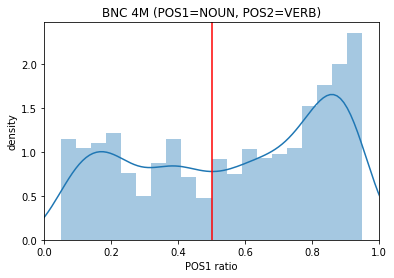

In [12]:
flexible_df = lemma_count_df[lemma_count_df.is_flexible]
dplot = sns.distplot(flexible_df.pos1_count / flexible_df.total_count, bins=20)
dplot.set(xlabel='POS1 ratio', ylabel="density", title='BNC 4M (POS1=%s, POS2=%s)' % (POS1, POS2))
dplot.set_xlim((0, 1))
dplot.axvline(x=0.5, color='r')
plt.show()

## Show Examples

In [13]:
# Top flexible POS1
lemma_count_df[(lemma_count_df['majority_tag'] == POS1) & (lemma_count_df['is_flexible'])].head(10)

,lemma,pos1_count,pos2_count,majority_tag,total_count,minority_count,minority_ratio,is_flexible
406,work,1665,1593,NOUN,3258,1593,0.488950,True
43,point,1534,469,NOUN,2003,469,0.234149,True
831,place,1643,341,NOUN,1984,341,0.171875,True
730,hand,1765,127,NOUN,1892,127,0.067125,True
2095,sort,1613,216,NOUN,1829,216,0.118097,True
309,change,889,858,NOUN,1747,858,0.491128,True
239,form,1272,354,NOUN,1626,354,0.217712,True
797,face,1185,281,NOUN,1466,281,0.191678,True
2301,head,1355,96,NOUN,1451,96,0.066161,True
2228,end,1171,244,NOUN,1415,244,0.172438,True


In [14]:
# Examples of inflexible POS1
lemma_count_df[(lemma_count_df['majority_tag'] == POS1) & (~lemma_count_df['is_flexible'])].head(10)

,lemma,pos1_count,pos2_count,majority_tag,total_count,minority_count,minority_ratio,is_flexible
335,time,5349,33,NOUN,5382,33,0.006132,False
241,way,3655,0,NOUN,3655,0,0.000000,False
275,thing,3512,0,NOUN,3512,0,0.000000,False
1999,man,3237,9,NOUN,3246,9,0.002773,False
299,people,2790,1,NOUN,2791,1,0.000358,False
353,year,2463,0,NOUN,2463,0,0.000000,False
918,day,2451,0,NOUN,2451,0,0.000000,False
6549,bit,2311,0,NOUN,2311,0,0.000000,False
522,case,2095,0,NOUN,2095,0,0.000000,False
1402,woman,2061,0,NOUN,2061,0,0.000000,False


In [15]:
# Examples of flexible POS2
lemma_count_df[(lemma_count_df['majority_tag'] == POS2) & (lemma_count_df['is_flexible'])].head(10)

,lemma,pos1_count,pos2_count,majority_tag,total_count,minority_count,minority_ratio,is_flexible
123,look,699,5893,VERB,6592,699,0.106038,True
433,use,791,2801,VERB,3592,791,0.220212,True
1597,need,587,2350,VERB,2937,587,0.199864,True
502,show,132,1843,VERB,1975,132,0.066835,True
1096,turn,226,1566,VERB,1792,226,0.126116,True
685,call,209,1558,VERB,1767,209,0.118280,True
5767,start,159,1269,VERB,1428,159,0.111345,True
1025,talk,119,1302,VERB,1421,119,0.083744,True
930,move,131,1272,VERB,1403,131,0.093371,True
973,hold,130,1251,VERB,1381,130,0.094135,True


In [16]:
# Examples of inflexible POS2
lemma_count_df[(lemma_count_df['majority_tag'] == POS2) & (~lemma_count_df['is_flexible'])].head(10)

,lemma,pos1_count,pos2_count,majority_tag,total_count,minority_count,minority_ratio,is_flexible
0,be,0,147915,VERB,147915,0,0.000000,False
29,have,3,51743,VERB,51746,3,0.000058,False
8,do,6,34673,VERB,34679,6,0.000173,False
2166,get,0,16679,VERB,16679,0,0.000000,False
52,say,10,14151,VERB,14161,10,0.000706,False
149,go,293,13786,VERB,14079,293,0.020811,False
118,know,0,12551,VERB,12551,0,0.000000,False
227,will,147,12273,VERB,12420,147,0.011836,False
642,can,35,11480,VERB,11515,35,0.003040,False
521,would,0,9894,VERB,9894,0,0.000000,False


## Chi-squared test that POS1 and POS2 are not equally likely to convert

In [17]:
base_pos1_is_base = lemma_count_df[lemma_count_df.majority_tag == POS1].pos1_count.sum()
base_pos2_is_base = lemma_count_df[lemma_count_df.majority_tag == POS2].pos2_count.sum()
base_pos1_not_base = lemma_count_df[lemma_count_df.majority_tag == POS1].pos2_count.sum()
base_pos2_not_base = lemma_count_df[lemma_count_df.majority_tag == POS2].pos1_count.sum()

In [18]:
print('Instances of base=%s, pos=%s (no conversion): %d' % (POS1, POS1, base_pos1_is_base))
print('Instances of base=%s, pos=%s (conversion): %d' % (POS1, POS2, base_pos1_not_base))
print('Instances of base=%s, pos=%s (no conversion): %d' % (POS2, POS2, base_pos2_is_base))
print('Instances of base=%s, pos=%s (conversion): %d' % (POS2, POS1, base_pos2_not_base))

Instances of base=NOUN, pos=NOUN (no conversion): 546566
Instances of base=NOUN, pos=VERB (conversion): 26429
Instances of base=VERB, pos=VERB (no conversion): 600328
Instances of base=VERB, pos=NOUN (conversion): 21369


In [19]:
print('Likelihood of %s converting: %0.9f' % (POS1, base_pos1_not_base/base_pos1_is_base))
print('Likelihood of %s converting: %0.9f' % (POS2, base_pos2_not_base/base_pos2_is_base))

Likelihood of NOUN converting: 0.048354636
Likelihood of VERB converting: 0.035595541


In [20]:
import scipy.stats
pvalue = scipy.stats.chi2_contingency([[base_pos1_is_base, base_pos1_not_base], [base_pos2_is_base, base_pos2_not_base]])[1]
print('p-value from chi-squared test:', pvalue)

p-value from chi-squared test: 4.140506884758993e-235
